---
title: "Exploratory Data Analysis"
format:
    html: 
        code-fold: false
---

<!-- After digesting the instructions, you can delete this cell, these are assignment instructions and do not need to be included in your final submission.  -->

{{< include instructions.qmd >}} 

# Code 



/var/folders/sj/4yswlk7n08x8jfcfnyw2vkqw0000gn/T/ipykernel_3697/3176648054.py:429: FutureWarning:

The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError



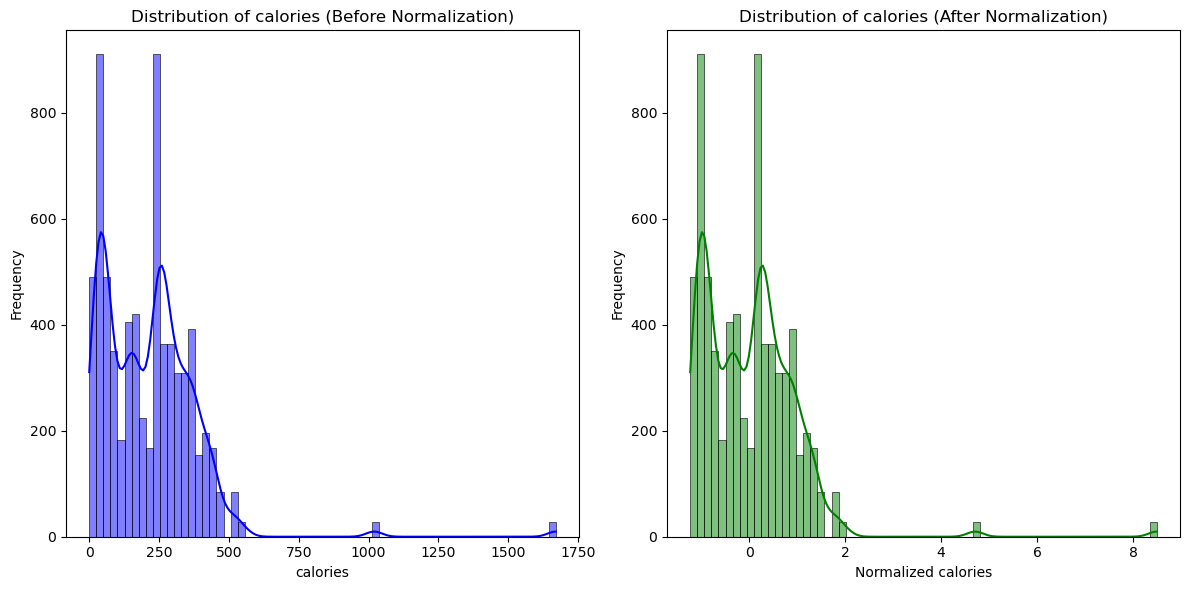

Missing Values Analysis:
                 Missing Count  Missing Percentage
phosphorus                6902           97.430830
potassium                 3304           46.640316
iron                       546            7.707510
calcium                    532            7.509881
fiber                      364            5.138340
disposal_method            168            2.371542
protein                     56            0.790514
sodium                      28            0.395257
calories                    28            0.395257
carbs                       28            0.395257
fat                         28            0.395257


In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import plotly.colors as pc
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.stats import skew, kurtosis, yeojohnson, pearsonr


class EDA:
    def __init__(self, data):
        self.data = data

    # Basic statistics
    def describe_data(self):
        return self.data.describe()

    # Scatterplot with optional line of best fit
    def plot_scatter(self, col1, col2, add_line_of_best_fit=False, remove_outliers=False):
        # Ensure no missing data in both columns
        data_clean = self.data[[col1, col2]].dropna()

        if remove_outliers:
            # Calculate Q1 (25th percentile) and Q3 (75th percentile) for both columns
            Q1 = data_clean[[col1, col2]].quantile(0.25)
            Q3 = data_clean[[col1, col2]].quantile(0.75)
            IQR = Q3 - Q1
        
            # Remove outliers based on the IQR rule
            data_clean = data_clean[~((data_clean[col1] < (Q1[col1] - 1.5 * IQR[col1])) | 
                                    (data_clean[col1] > (Q3[col1] + 1.5 * IQR[col1])) |
                                    (data_clean[col2] < (Q1[col2] - 1.5 * IQR[col2])) | 
                                    (data_clean[col2] > (Q3[col2] + 1.5 * IQR[col2])))]
    
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=data_clean, x=col1, y=col2)
        plt.title(f'Scatterplot of {col1} vs {col2}')
        plt.xlabel(col1)
        plt.ylabel(col2)
    
        if add_line_of_best_fit:
            # Fit a linear regression model
            model = LinearRegression()
            X = data_clean[[col1]]  # Ensure there are no missing values
            y = data_clean[col2]
            model.fit(X, y)
            y_pred = model.predict(X)
            plt.plot(X, y_pred, color='red', label='Line of Best Fit')
            plt.legend()

        plt.show()
        
        #return plt
    
    def plot_correlation_heatmap(self):
        # Select numeric columns
        numeric_data = self.data.select_dtypes(include=np.number)
        
        # Compute the correlation matrix
        corr_matrix = numeric_data.corr()

        # Plot the heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap of Numeric Columns')
        plt.show()
        # return plt
    
    def voronoi_pie_slider(self, year_col, category_cols, output_html_path="../../assets/voronoi.html"):
        # Prepare data for the pie chart
        years = sorted(self.data[year_col].unique())

        # Define a color map for the categories using Plotly's qualitative color scale
        color_scale = pc.qualitative.Set3  # You can choose other color scales such as 'Set2', 'Set3', etc.
        
        # Ensure there are enough colors for the number of categories
        if len(category_cols) > len(color_scale):
            raise ValueError("Not enough colors in the selected color scale for the number of categories.")
        
        # Map categories to colors from the color scale
        color_map = {category: color_scale[i] for i, category in enumerate(category_cols)}

        fig = go.Figure()

        # Iterate over each year and create a frame for animation
        for i, year in enumerate(years):
            year_data = self.data[self.data[year_col] == year]
            values = year_data[category_cols].sum(axis=0)

            # Set the color of the pie slices according to the category
            colors = [color_map[category] for category in category_cols]

            fig.add_trace(
                go.Pie(
                    labels=category_cols,
                    values=values,
                    name=str(year),
                    hoverinfo='label+percent',  # Hover shows the label and percentage
                    hole=0.3,  # Add a hole to make the pie chart look like a donut
                    visible=(year == 2023),  # Make 2023 visible by default
                    marker=dict(colors=colors)  # Apply the fixed color map
                )
            )

        fig.update_layout(
            title='Distribution of Food Waste by Categories',
            showlegend=True,
            height=600,
            width=800,
            margin=dict(t=50, b=100, l=50, r=50),  # Add margin at the bottom for the buttons
            updatemenus=[{
                'buttons': [
                    {
                        'args': [{'visible': [i == j for i in range(len(years))]}],
                        'label': str(year),
                        'method': 'update'
                    } for j, year in enumerate(years)
                ],
                'direction': 'left',
                'showactive': True,
                'type': 'buttons',
                'x': 0.5,  
                'xanchor': 'center', 
                'y': -0.2, 
                'yanchor': 'top',
                'font': {'size': 10},  # Smaller button text
                'pad': {'r': 10, 't': 10}
            }]
        )

        # Show the plot
        fig.show()
        fig.write_html(output_html_path)

    def analyze_missing_values(self):
        missing_data = self.data.isnull().sum()
        missing_percentage = (missing_data / len(self.data)) * 100
        
        # Create a DataFrame to display missing data info
        missing_df = pd.DataFrame({
            'Missing Count': missing_data,
            'Missing Percentage': missing_percentage
        }).sort_values(by='Missing Count', ascending=False)
        
        print("Missing Values Analysis:")
        print(missing_df[missing_df['Missing Count'] > 0])
        #return missing_df
    
    def plot_distribution(self, col):
        plt.figure(figsize=(8, 6))
        sns.histplot(self.data[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()
        #return plt
        
    # Boxplot for outlier detection
    def plot_boxplot(self, col):
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=self.data[col])
        plt.title(f'Boxplot of {col}')
        plt.ylabel(col)
        plt.show()
        #return plt

    # Pairplot for relationships
    def plot_pairplot(self, cols=None):
        if cols is None:
            cols = self.data.select_dtypes(include=np.number).columns
        
        sns.pairplot(self.data[cols], diag_kind='kde')
        plt.suptitle('Pairplot of Selected Columns', y=1.02)
        plt.show()
        #return plt
    
    # Countplot for categorical data
    def plot_countplot(self, col):
        plt.figure(figsize=(8, 6))
        sns.countplot(data=self.data, x=col, order=self.data[col].value_counts().index)
        plt.title(f'Countplot of {col}')
        plt.xlabel(col)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()
        #return plt
    
    def plot_mean_nutrients_by_disposal(self, disposal_col, nutrient_cols):
        grouped_data = self.data.groupby(disposal_col)[nutrient_cols].mean()
        grouped_data.plot(kind='bar', figsize=(12, 8), colormap='viridis')
        plt.title(f'Mean Nutrient Content by {disposal_col}')
        plt.ylabel('Mean Nutrient Values')
        plt.xlabel(disposal_col)
        plt.xticks(rotation=45)
        plt.legend(title='Nutrient')
        plt.show()
        #return plt
    
    def plot_scatter_matrix(self, disposal_cols, nutrient_cols):
        selected_cols = disposal_cols + nutrient_cols
        sns.pairplot(self.data[selected_cols], diag_kind='kde')
        plt.suptitle('Scatterplot Matrix: Disposal Methods vs Nutrient Content', y=1.02)
        plt.show()
        #return plt
    
    def plot_disposal_nutrient_correlation(self, disposal_cols, nutrient_cols):
        selected_data = self.data[disposal_cols + nutrient_cols]
        corr_matrix = selected_data.corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap: Disposal Methods vs Nutrient Content')
        plt.show()
        #return plt
    
    def plot_nutrient_boxplot_by_disposal(self, disposal_col, nutrient_col, bins=5):
        # Create bins for the disposal column
        plt.figure(figsize=(10, 6))
        sns.boxplot(data=self.data, x=nutrient_col, y=disposal_col)
        plt.title(f'{disposal_col} by {nutrient_col}')
        plt.xlabel(nutrient_col)
        plt.ylabel(disposal_col)
        plt.xticks(rotation=45)
        plt.show()
        #return plt

    def plot_scatter_with_regression(self, disposal_col, nutrient_col):
        plt.figure(figsize=(10, 6))
        sns.regplot(data=self.data, x=nutrient_col, y=disposal_col, scatter_kws={'alpha': 0.7}, line_kws={'color': 'red'})
        plt.title(f'{disposal_col} vs {nutrient_col} with Regression Line')
        plt.xlabel(nutrient_col)
        plt.ylabel(disposal_col)
        plt.show()
        #return plt

    def plot_disposal_nutrient_pairplot(self, disposal_cols, nutrient_cols):
        subset = self.data[disposal_cols + nutrient_cols]
        sns.pairplot(subset, corner=True, diag_kind='kde', plot_kws={'alpha': 0.6})
        plt.suptitle('Pairplot of Disposal and Nutrient Features', y=1.02)
        plt.show()
        #return plt

    def plot_hexbin(self, disposal_col, nutrient_col, gridsize=30):
        plt.figure(figsize=(10, 6))
        plt.hexbin(self.data[nutrient_col], self.data[disposal_col], gridsize=gridsize, cmap='coolwarm', mincnt=1)
        plt.colorbar(label='Count')
        plt.title(f'Hexbin Plot of {disposal_col} vs {nutrient_col}')
        plt.xlabel(nutrient_col)
        plt.ylabel(disposal_col)
        plt.show()
        #return plt


    def plot_kde_2d(self, disposal_col, nutrient_col):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(
            data=self.data, x=nutrient_col, y=disposal_col, cmap='coolwarm', fill=True, alpha=0.6
        )
        plt.title(f'2D KDE of {disposal_col} vs {nutrient_col}')
        plt.xlabel(nutrient_col)
        plt.ylabel(disposal_col)
        plt.show()
        #return plt

    def plot_jointplot(self, disposal_col, nutrient_col):
        sns.jointplot(
            data=self.data, x=disposal_col, y=nutrient_col, kind='reg', height=8, ratio=5, marginal_kws={'fill': True}
        )
        plt.suptitle(f'Jointplot of {nutrient_col} vs {disposal_col}', y=1.02)
        plt.show()
        #return plt

    def plot_disposal_nutrient_correlation(self, disposal_cols, nutrient_cols):
        correlation_data = self.data[disposal_cols + nutrient_cols].corr()
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(correlation_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Correlation Heatmap of Disposal and Nutrient Columns')
        plt.show()
    def plot_time_series(self):
        # Ensure that 'year' is in the data and is of numeric type
        if 'year' not in self.data.columns:
            raise ValueError("The dataset must contain a 'year' column.")

        # Group by year and calculate the sum of 'rescue', 'recycling', and 'foodwaste'
        time_series_data = self.data.groupby('year')[['rescue', 'recycling', 'foodwaste']].sum()

        # Create a Plotly figure
        fig = go.Figure()

        # Add traces for each variable (rescue, recycling, foodwaste)
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['rescue'], mode='lines+markers', name='Rescue (Donations)', line=dict(color='green')))
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['recycling'], mode='lines+markers', name='Recycling', line=dict(color='blue')))
        fig.add_trace(go.Scatter(x=time_series_data.index, y=time_series_data['foodwaste'], mode='lines+markers', name='Food Waste', line=dict(color='red')))

        # Update layout
        fig.update_layout(
            title='Rescue, Recycling, and Food Waste Over the Years',
            xaxis_title='Year',
            yaxis_title='Tons',
            template='plotly_dark', 
            legend_title='Disposal Method',
            showlegend=True
        )
        fig.write_html("../../assets/wastemethod.html")
        fig.show()
        #return fig
    
    def plot_us_dollars_surplus(self):
        # Ensure that 'year' and 'us_dollars_surplus' are in the data and are of numeric type
        if 'year' not in self.data.columns:
            raise ValueError("The dataset must contain a 'year' column.")
        if 'us_dollars_surplus' not in self.data.columns:
            raise ValueError("The dataset must contain a 'us_dollars_surplus' column.")

        # Group by year and calculate the sum of 'us_dollars_surplus'
        time_series_data = self.data.groupby('year')['us_dollars_surplus'].sum()

        # Create a Plotly figure
        fig = go.Figure()

        # Add trace for us_dollars_surplus
        fig.add_trace(go.Scatter(x=time_series_data.index, 
                                y=time_series_data, 
                                mode='lines+markers', 
                                name='US Dollars Surplus', 
                                line=dict(color='purple')))

        # Update layout
        fig.update_layout(
            title='Time Series of US Dollars Surplus From Wasted Food Over the Years',
            xaxis_title='Year',
            yaxis_title='US Dollars Surplus',
            template='plotly_dark',  # Optional: you can use different themes like plotly, plotly_dark, ggplot2, etc.
            showlegend=True
        )

        # Show the plot
        fig.show()
        fig.write_html("../../assets/dollarsurplus.html")
        #return fig
    
    def perform_clustering(self, n_clusters=3):
        """Apply K-Means clustering to numeric columns."""
        numeric_data = self.data.select_dtypes(include=['float64', 'int64'])

        # Drop rows with NaNs
        cleaned_data = numeric_data.dropna()

        # Perform K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(cleaned_data)

        # Add cluster labels back to the cleaned data
        cleaned_data['Cluster'] = cluster_labels

        return cleaned_data

    def dimensionality_reduction(self, n_components=2):
        """Perform PCA for dimensionality reduction."""
        numeric_data = self.data.select_dtypes(include=['float64', 'int64'])
        cleaned_data = numeric_data.dropna()
        pca = PCA(n_components=n_components)
        self.pca_components = pca.fit_transform(cleaned_data)
        return pd.DataFrame(self.pca_components, columns=[f'PC{i+1}' for i in range(n_components)])
    
    def analyze_distribution(self):
        """Calculate and print skewness and kurtosis for all numeric columns."""
        results = {}
        for col in self.data.select_dtypes(include=['float64', 'int64']).columns:
            skewness = skew(self.data[col].dropna())
            kurt = kurtosis(self.data[col].dropna())
            results[col] = {'Skewness': skewness, 'Kurtosis': kurt}
        return pd.DataFrame(results).T

    def apply_transformations(self):
        """Apply transformations to skewed data."""
        self.transformed_data = self.data.copy()
        for col in self.data.select_dtypes(include=['float64', 'int64']).columns:
            skewness = skew(self.data[col].dropna())
            if abs(skewness) > 1:  # Consider skewness threshold
                self.transformed_data[col] = np.log1p(self.data[col])
        return self.transformed_data

    def normalize_data(self, method='z-score'):
        """Apply normalization techniques (z-score or min-max)."""
        self.normalized_data = self.data.copy()
        numeric_cols = self.data.select_dtypes(include=['float64', 'int64']).columns
        if method == 'z-score':
            scaler = StandardScaler()
        elif method == 'min-max':
            scaler = MinMaxScaler()
        else:
            raise ValueError("Method must be 'z-score' or 'min-max'.")
        
        self.normalized_data[numeric_cols] = scaler.fit_transform(self.data[numeric_cols])
        return self.normalized_data

    def feature_engineering(self):
        """Example feature engineering by categorizing food categories."""
        self.data['food_category_encoded'] = self.data['food_category'].astype('category').cat.codes
        return self.data

        



data = pd.read_csv('../../data/processed-data/food_merged.csv')
category_columns = [
    'tons_donations', 'tons_industrial_uses', 'tons_animal_feed',
    'tons_anaerobic_digestion', 'tons_composting', 'tons_not_harvested',
    'tons_incineration', 'tons_land_application', 'tons_landfill',
    'tons_sewer', 'tons_dumping'
]
data['total'] = data[category_columns].sum(axis=1)

# Calculate the percentage of total for each column
percentage_df = data[category_columns].div(data['total'], axis=0)

# Find the column with the maximum percentage for each row 
# to create a new column called disposal method 
# this indicates the primary disposal method
data['disposal_method'] = percentage_df.idxmax(axis=1)
data['disposal_method'] = data['disposal_method'].str.replace('tons_', '', regex=False)

# Drop the total column if no longer needed
data.drop(columns=['total'], inplace=True)

# Create new columns: rescue, recycling, and foodwaste
data['tons_rescue'] = data['tons_donations']
data['tons_recycling'] = data[['tons_industrial_uses', 'tons_animal_feed', 'tons_anaerobic_digestion', 'tons_composting']].sum(axis=1)
data['tons_foodwaste'] = data[['tons_not_harvested', 'tons_incineration', 'tons_land_application', 'tons_landfill', 'tons_sewer', 'tons_dumping']].sum(axis=1)

# Create a donation binary column to indicate if donations exist
data['donation_bin'] = np.where(data['tons_donations'] > 0, 1, 0)
eda = EDA(data)

column = 'calories'

# Original data distribution
plt.figure(figsize=(12, 6))

# Before normalization
plt.subplot(1, 2, 1)
sns.histplot(eda.data[column], kde=True, color='blue')
plt.title(f'Distribution of {column} (Before Normalization)')
plt.xlabel(f'{column}')
plt.ylabel('Frequency')

# Normalize the data
eda.normalize_data(method='z-score')

# After normalization
plt.subplot(1, 2, 2)
sns.histplot(eda.normalized_data[column], kde=True, color='green')
plt.title(f'Distribution of {column} (After Normalization)')
plt.xlabel(f'Normalized {column}')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

eda.analyze_missing_values()

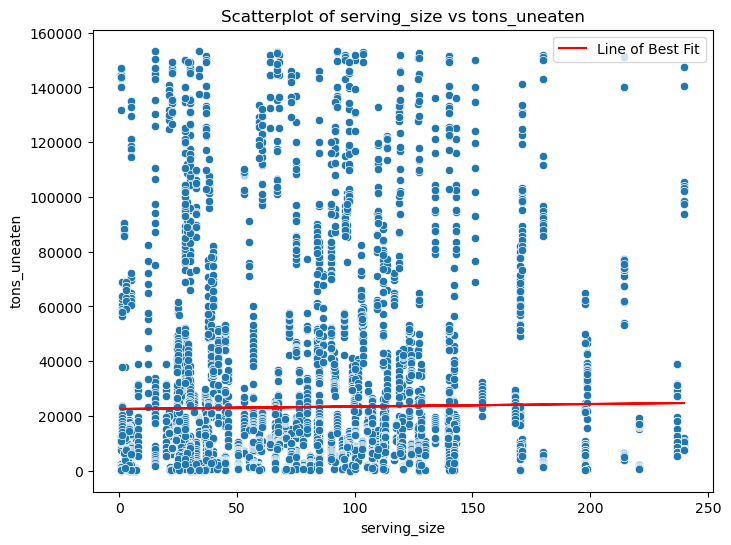

Correlation coefficient: 0.3415795157511618
P-value: 2.368552259759485e-06


In [127]:


#2 trues at the end of this class method add a trend line and get rid of outliers
eda.plot_scatter('serving_size', 'tons_uneaten', True, True)

df_clean = data.replace([float('inf'), float('-inf')], float('nan')).dropna()

correlation, p_value = pearsonr(df_clean['serving_size'], df_clean['tons_uneaten'])

print(f"Correlation coefficient: {correlation}")
print(f"P-value: {p_value}")


In the context of our study, the plot above, along with Pearson’s correlation coefficient of 0.34, reveals a moderate positive correlation between the serving size of a food item and the tons left uneaten. This suggests that larger serving sizes are associated with greater amounts of food waste. Furthermore, the p-value associated with this correlation is extremely small, indicating a statistically significant relationship. As a result, we can confidently reject the null hypothesis that there is no correlation between serving size and food waste, supporting the idea that serving size is an important factor contributing to food waste patterns in our dataset.

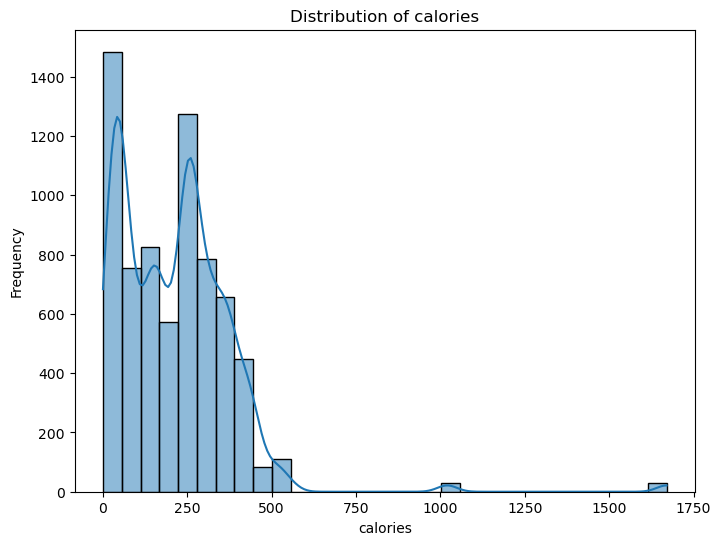

In [128]:
eda.plot_distribution(col='calories')

The histogram of calories above demonstrates a bimodal distribution, with one peak in the range of 0-24 calories and another around 250 calories. The concentration of data in these two distinct ranges suggests that food items with low and moderate calorie content dominate the dataset. Additionally, the presence of outliers, particularly at higher calorie values, could be indicative of high-calorie, meal-prep food options. These items, likely designed for larger servings or specialized dietary needs, may contribute disproportionately to food waste, reflecting consumer preference patterns or over-purchasing behavior. This insight warrants further investigation into the relationship between food type, portion size, and waste generation.

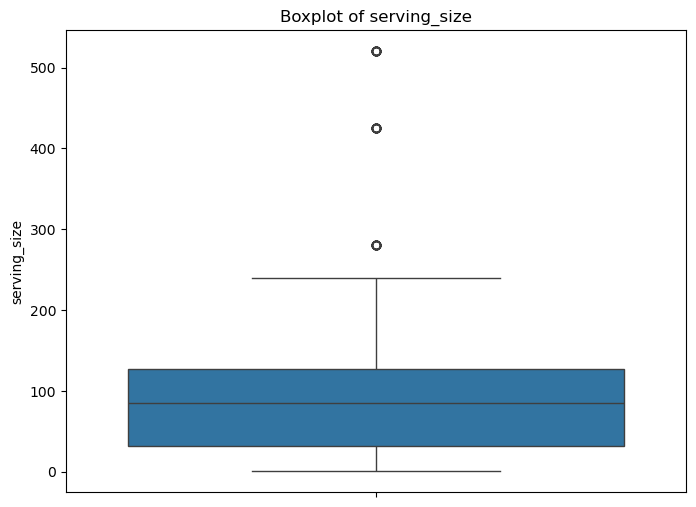

In [129]:
eda.plot_boxplot(col='serving_size')

The boxplot of serving size reveals a median value of approximately 80 grams, indicating that the central tendency of serving sizes is relatively small. However, the plot also shows outliers beyond the 75th percentile, with some data points reaching up to 500 grams. These larger values likely correspond to meal kits or pre-packaged meals, which typically have larger portion sizes. The presence of these outliers suggests that a subset of food items, particularly those designed for meal preparation or larger servings, may contribute to higher levels of waste. This highlights the importance of considering portion size in waste reduction strategies, especially for meal kits and large-serving products.

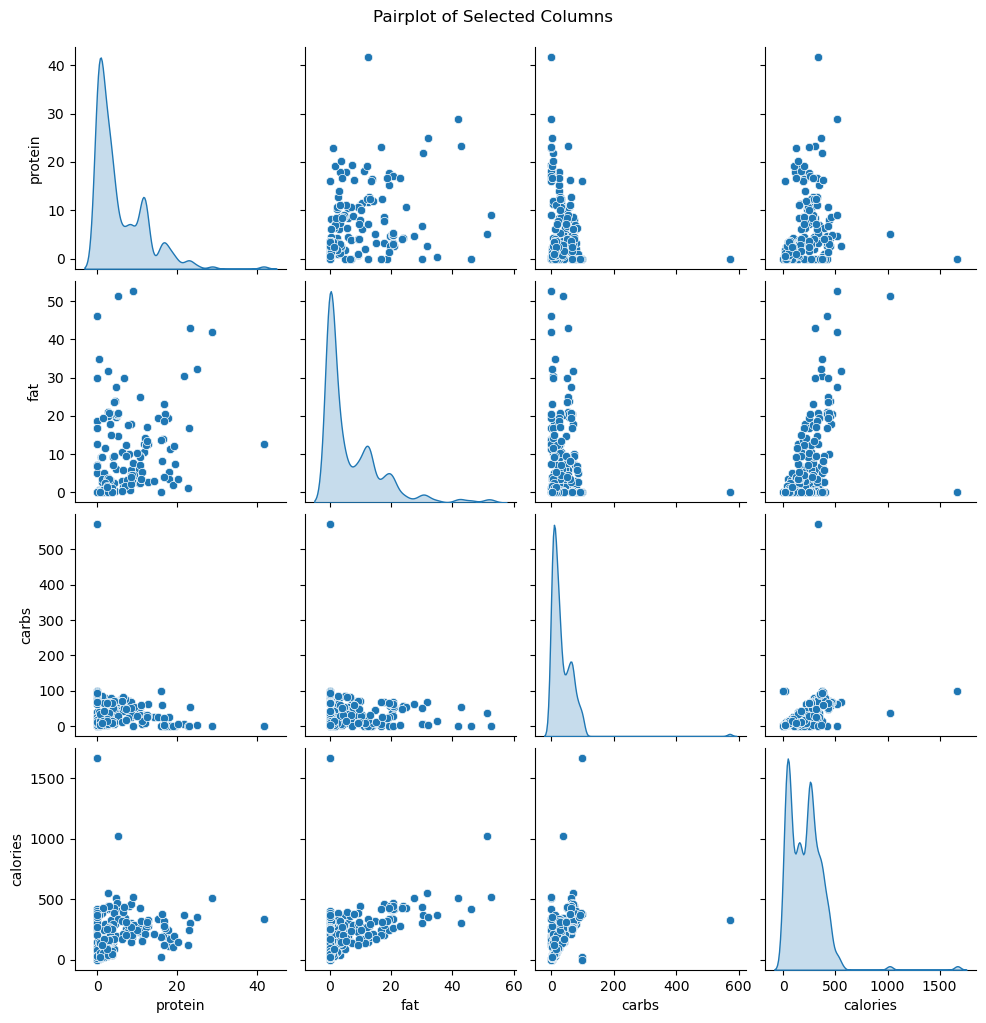

In [130]:
eda.plot_pairplot(cols=['protein', 'fat', 'carbs', 'calories'])

The pair plot of macronutrients provides valuable insights into the relationships between various nutritional components. It reveals a clear positive correlation between calories and fats, suggesting that higher fat content in foods is generally associated with higher caloric values. Similarly, fats and carbohydrates are positively related, indicating that foods rich in fats tend to also contain higher amounts of carbohydrates. Additionally, the plot shows that foods with lower carbohydrate content often have higher protein levels, which may suggest a trend toward protein-dense, low-carb options. Lastly, there is a strong positive relationship between proteins and calories, further reinforcing that higher protein foods tend to be more calorie-dense. These patterns could guide nutrition-based interventions for reducing food waste, particularly for food categories with high fat, carbohydrate, and calorie content.

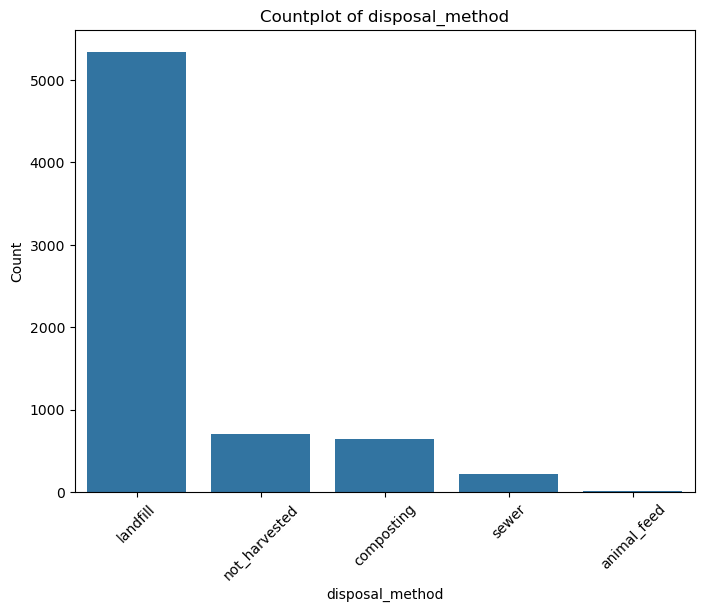

In [131]:
eda.plot_countplot(col='disposal_method')


The countplot of the primary disposal method clearly illustrates that the majority of food waste is disposed of in landfills, followed by composting, unharvested food, waste sent to the sewer, and recycling for animal feed, land application, and industrial uses. This distribution highlights the significant opportunity for a nutrition-based intervention to reduce food waste, particularly by targeting the food categories most commonly sent to landfills or underutilized for composting and animal feed. By optimizing food production and consumption practices through such interventions, the environmental impact of food waste can be mitigated, potentially shifting the focus toward more sustainable disposal methods

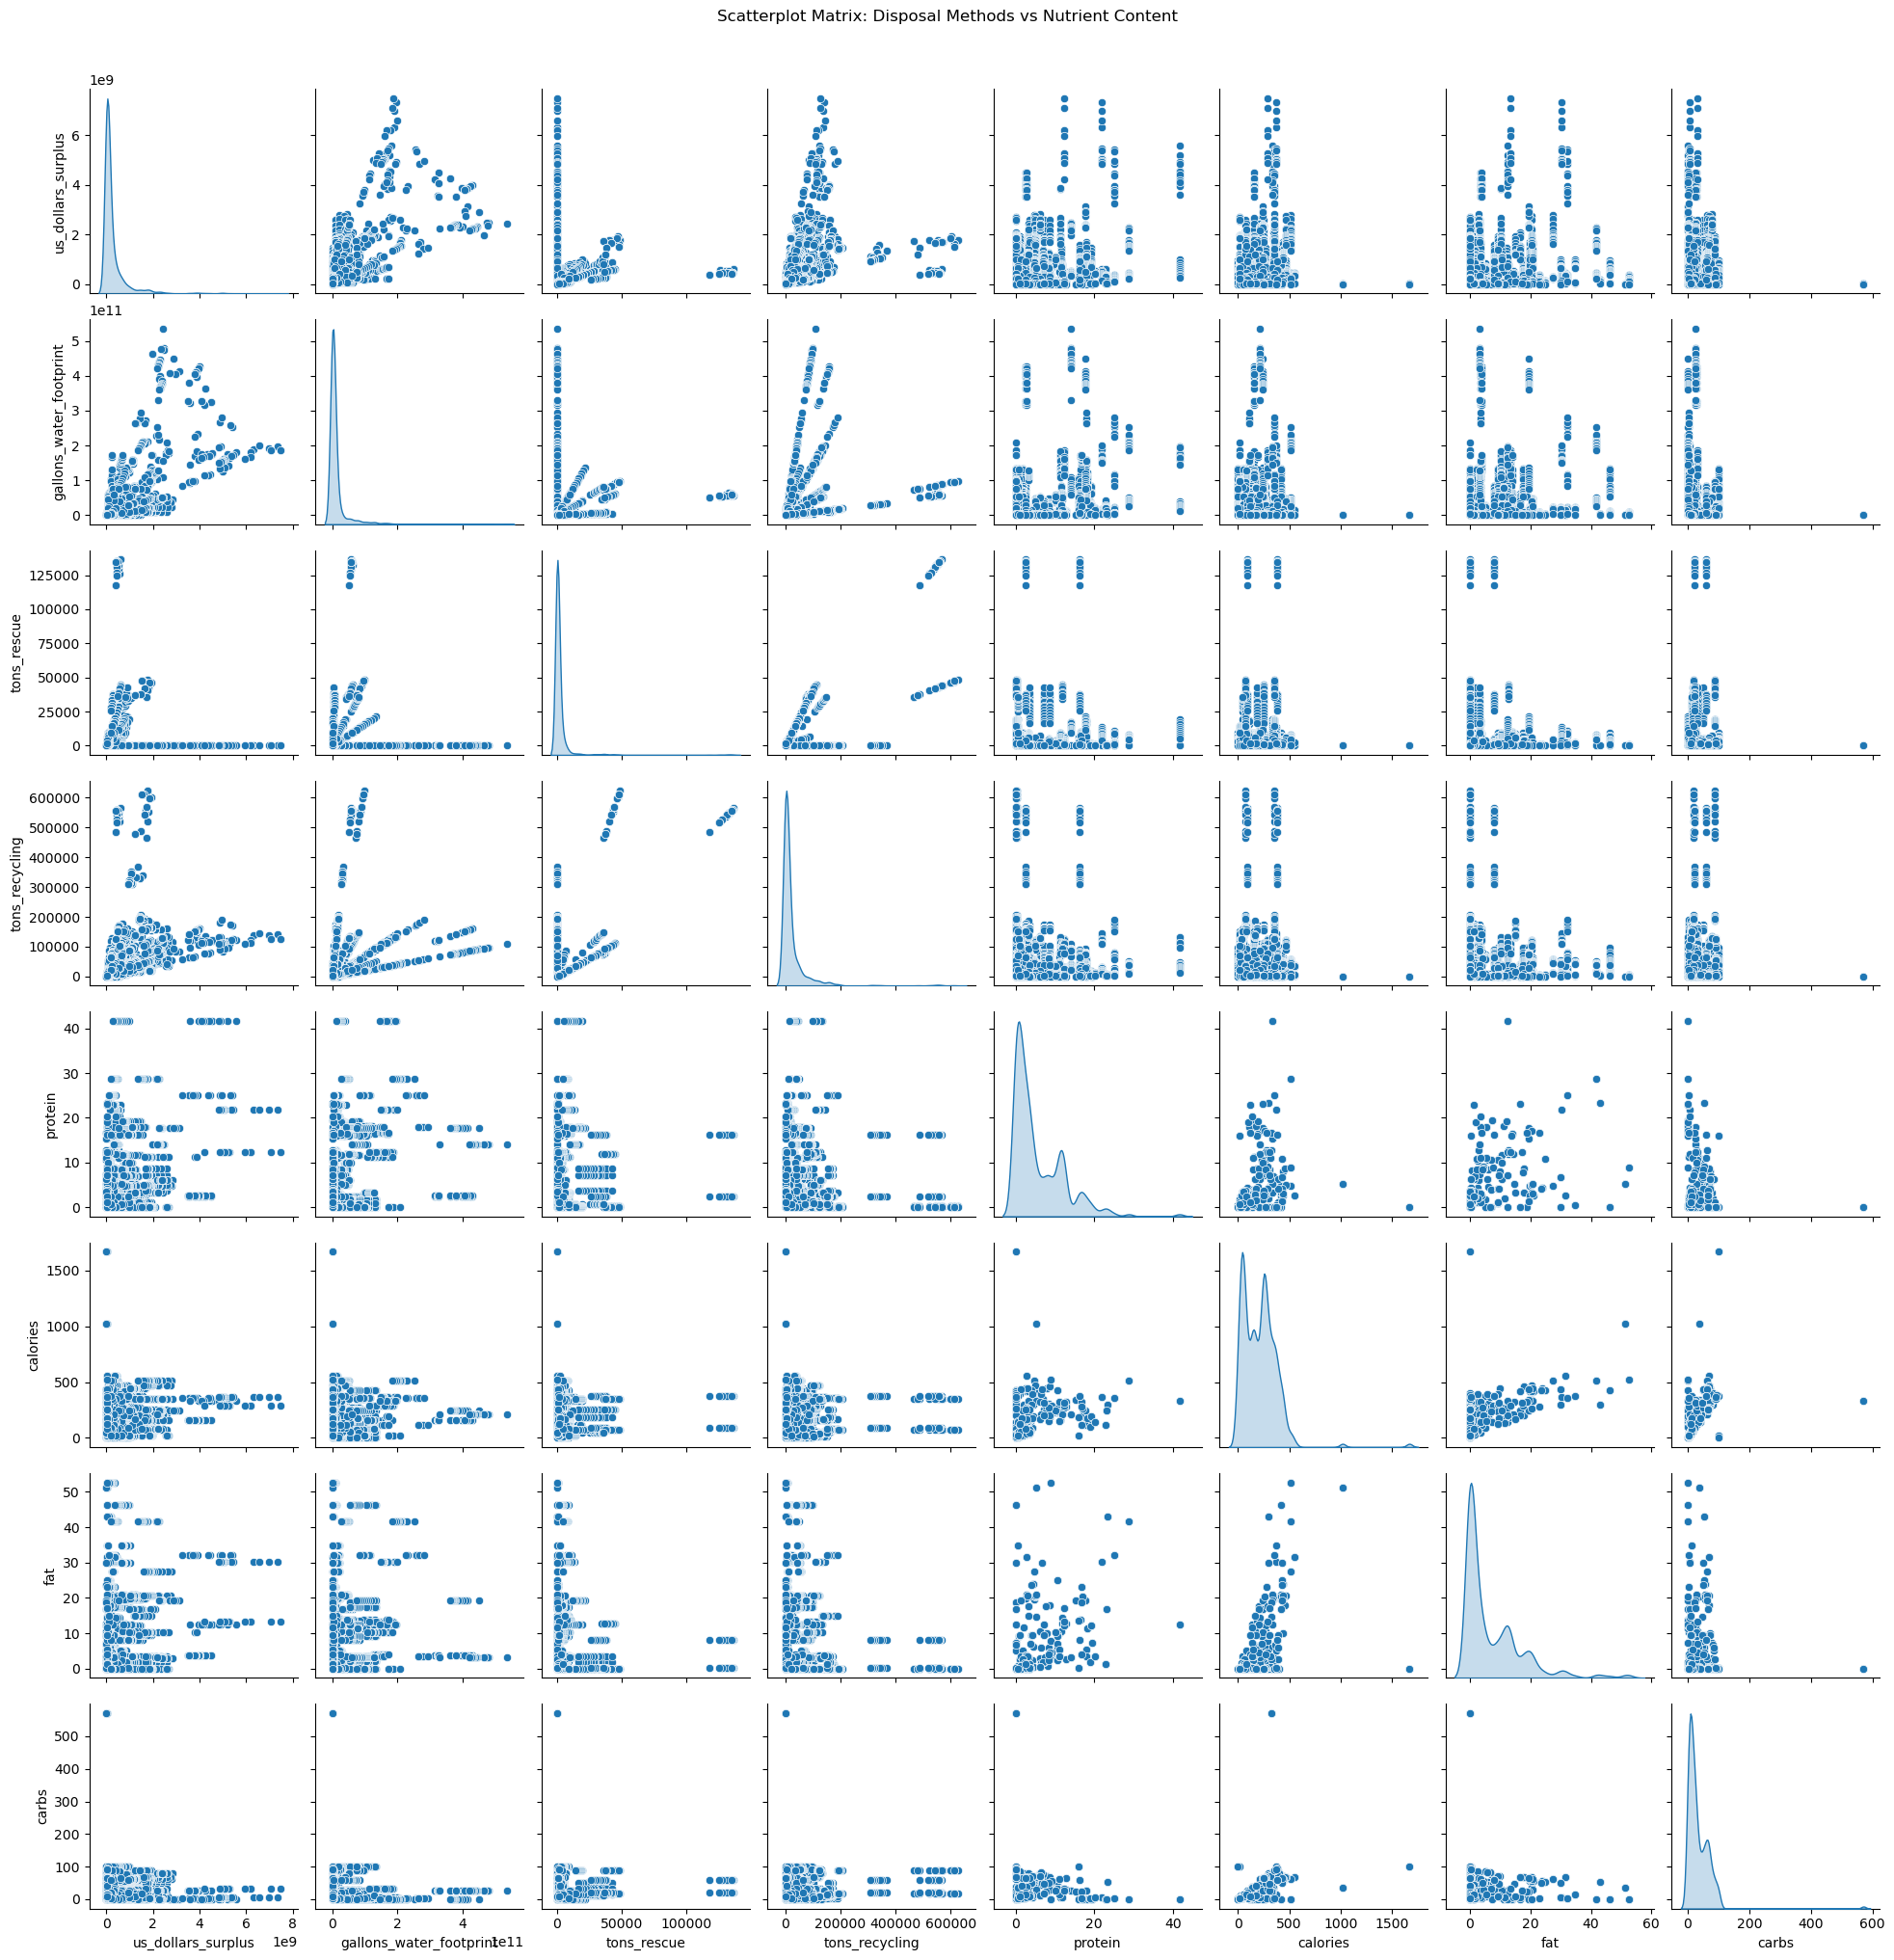

In [132]:
production_cols = ['us_dollars_surplus', 'gallons_water_footprint', 'tons_rescue', 'tons_recycling'
]
nutrient_cols = ['protein', 'calories', 'fat', 'carbs']
eda.plot_scatter_matrix(production_cols, nutrient_cols)

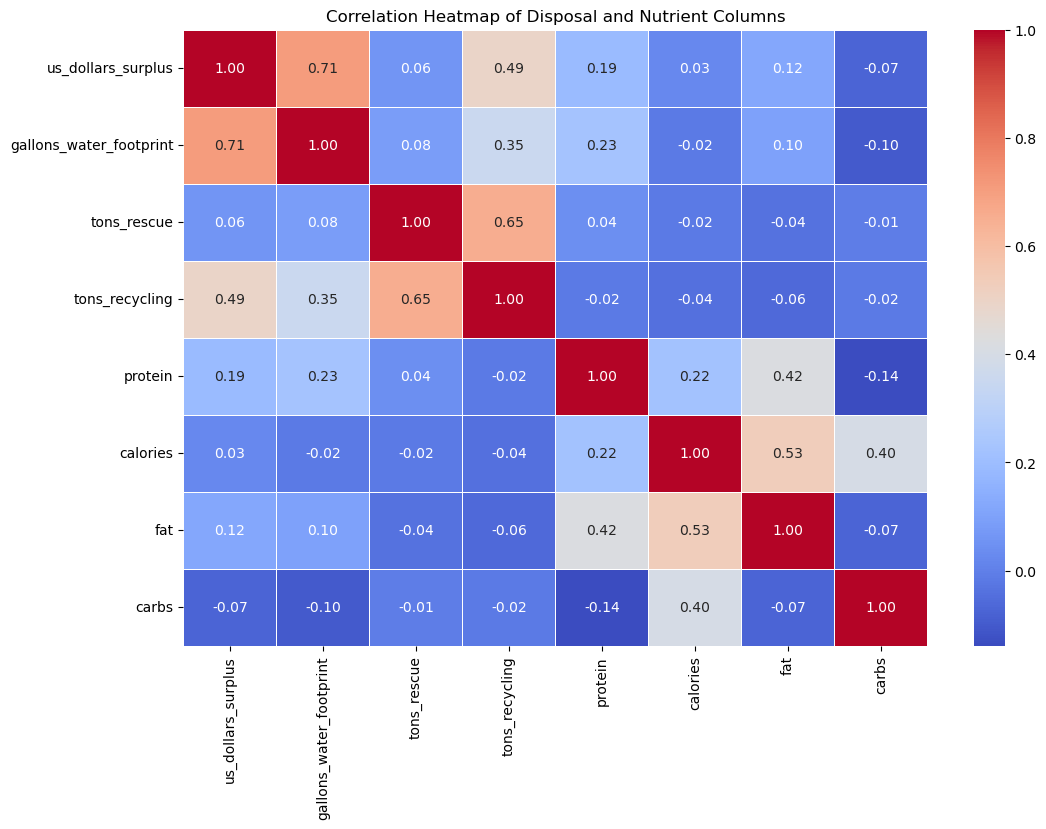

In [133]:
eda.plot_disposal_nutrient_correlation(production_cols, nutrient_cols)

The correlational heatmap above highlights the relationships between us_dollars_surplus, protein, and gallons_water_footprint. It reveals that high-protein and high-fat foods are associated with resource-intensive upstream processes, which not only have a negative environmental impact but also contribute significantly to economic losses when these foods are wasted. This underscores the need to address both the environmental and financial consequences of food waste, particularly for resource-heavy food categories.

Furthermore, the heatmap indicates a strong positive correlation between food waste recycling and potential food donation, as evidenced by the high correlation coefficient. This suggests that food waste that is recycled is often the same food that could have been donated, highlighting the opportunity to redirect edible waste to charitable causes, reducing waste while benefiting communities.

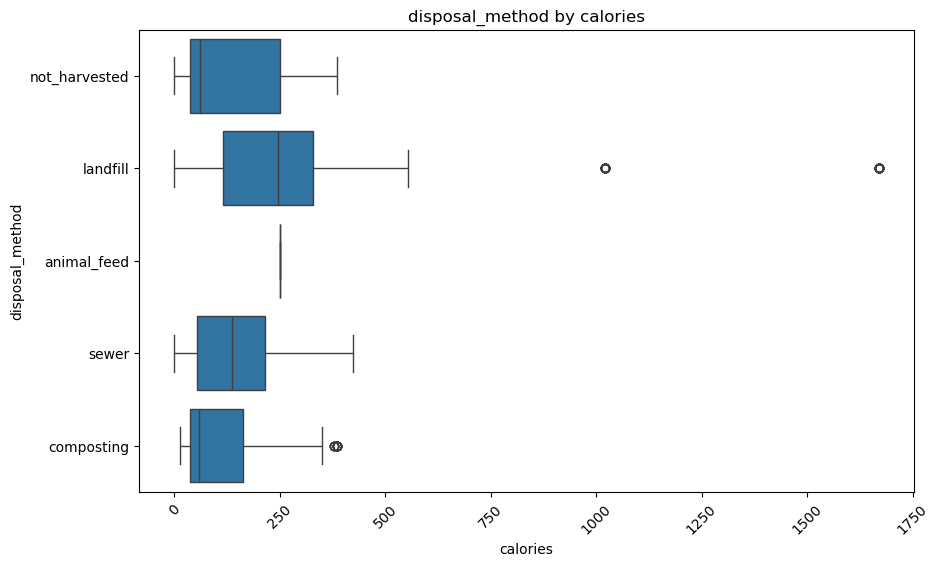

In [134]:
eda.plot_nutrient_boxplot_by_disposal(disposal_col='disposal_method', nutrient_col='calories')

The above boxplots reveal that, on average, higher-calorie foods are more likely to end up as landfill waste, be disposed of in the sewer, or be recycled as animal feed. In contrast, foods with lower calorific values tend to be composted or not harvested. This trend suggests that higher-calorie foods, which are often resource-intensive, may be more difficult to manage or repurpose, leading to their higher likelihood of disposal in environmentally damaging ways. Conversely, lower-calorie foods, which may have lower environmental impacts, are more commonly handled through sustainable methods such as composting or are left unharvested.

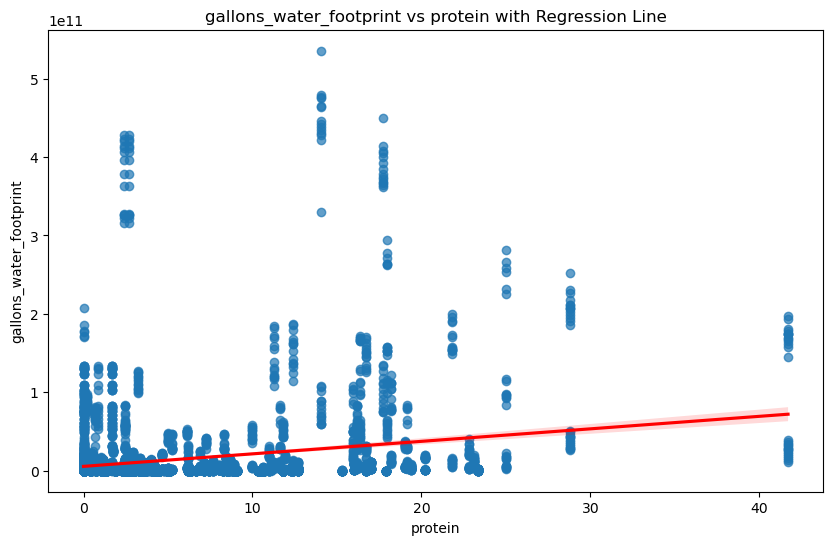

In [135]:
eda.plot_scatter_with_regression(disposal_col='gallons_water_footprint', nutrient_col='protein')

The above scatter plot, with an accompanying trendline, clearly demonstrates the positive relationship between protein-rich foods and the gallons of water associated with their upstream manufacturing process. For instance, protein-rich foods such as meats, eggs, dairy products, and especially beef, require significant amounts of water in their production. This underscores the negative environmental impact of these food items, highlighting their substantial water footprint and the broader sustainability concerns associated with their consumption.

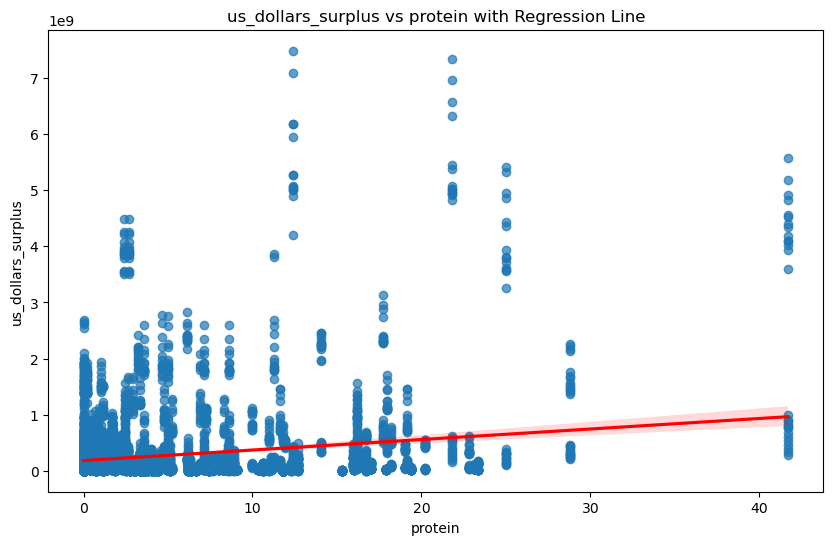

In [136]:
eda.plot_scatter_with_regression(disposal_col='us_dollars_surplus', nutrient_col='protein')

The above scatter plot, with an accompanying trendline, illustrates a clear positive relationship between protein-rich foods and the U.S. dollars surplus value associated with wasted food. As the protein content in the food increases, the economic loss associated with its waste also rises. This trend emphasizes the financial impact of wasting high-protein foods, such as meats, dairy, and eggs, which not only contribute to higher environmental costs but also result in significant monetary losses when wasted.


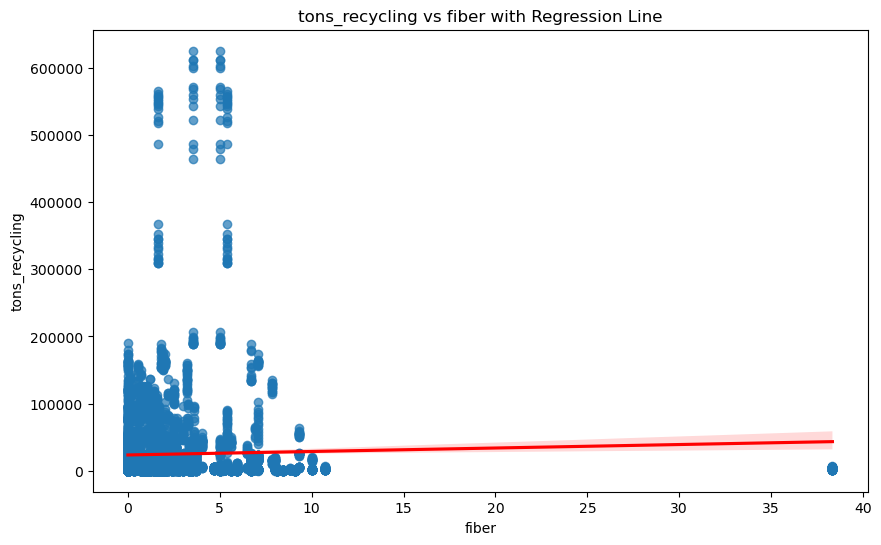

In [137]:
eda.plot_scatter_with_regression(disposal_col='tons_recycling', nutrient_col='fiber')

The above scatter plot reveals a weak positive correlation between the fiber content of food (in grams) and the tons of food recycled. This suggests that fiber-rich foods, often organic and sourced from natural origins, tend to be recycled more frequently. Foods with higher fiber content contribute to greater amounts of recycled waste, possibly due to their biodegradability and the increased likelihood of their being composted or repurposed in recycling processes.

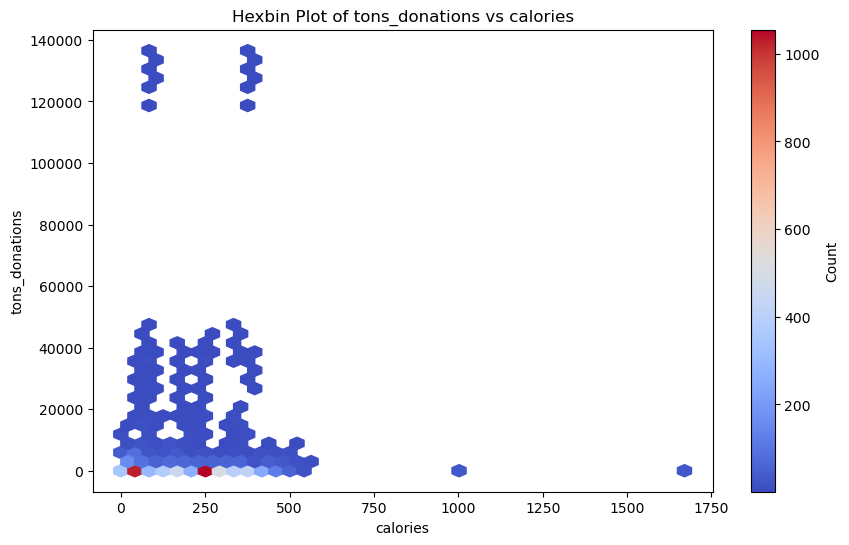

In [138]:
eda.plot_hexbin(disposal_col='tons_donations', nutrient_col='calories', gridsize=40)

The above hexbin plot indicates that a significant amount of donated food (food used for rescue) comes from food sources with calorie ranges of 50-120 and 250-400. This pattern likely points to specific food types that are more frequently donated, possibly due to their lower calorie content or because they represent food categories commonly involved in food rescue efforts. These calorie ranges could reflect foods that are either smaller portion sizes or pre-packaged items often rescued before reaching expiration.

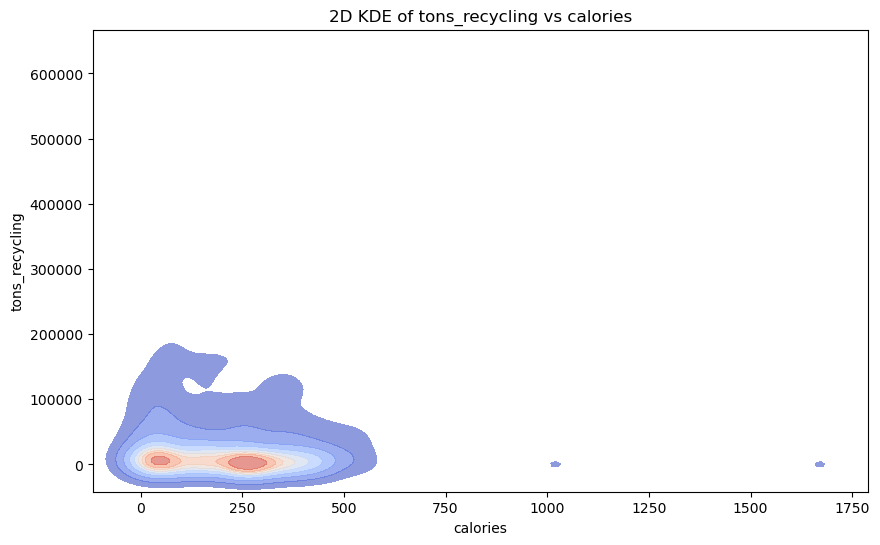

In [139]:
eda.plot_kde_2d(disposal_col='tons_recycling', nutrient_col='calories')

The above kernel density estimation plot shows that food with a calorific value between 80-160 calories is most frequently recycled. This suggests that foods with lower caloric content have a higher likelihood of being repurposed, indicating that when these foods are wasted, they are more likely to be directed towards recycling or alternative uses. The plot highlights the potential for effectively redirecting lower-calorie food waste towards more sustainable practices.

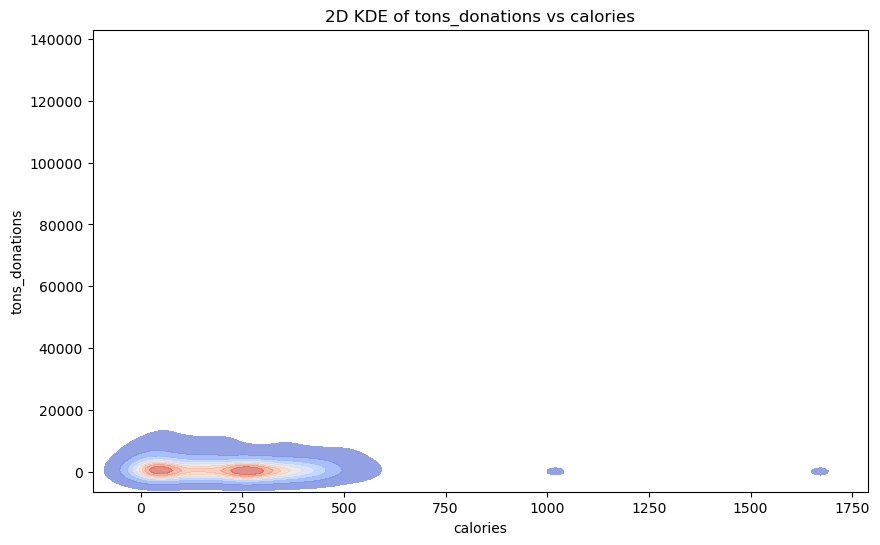

In [140]:
eda.plot_kde_2d(disposal_col='tons_donations', nutrient_col='calories')

The above Kernel Density Estimation (KDE) plot of calories versus tons donated indicates that foods with lower calorific values are donated the most. This suggests that low-calorie foods, which are often healthier or less resource-intensive to produce, are more likely to be rescued and redistributed. This trend may reflect both consumer preferences and organizational efforts to donate foods that are easier to store and distribute. Additionally, lower-calorie foods might be less perishable or more in demand for donation programs, leading to their higher donation rates compared to higher-calorie foods.

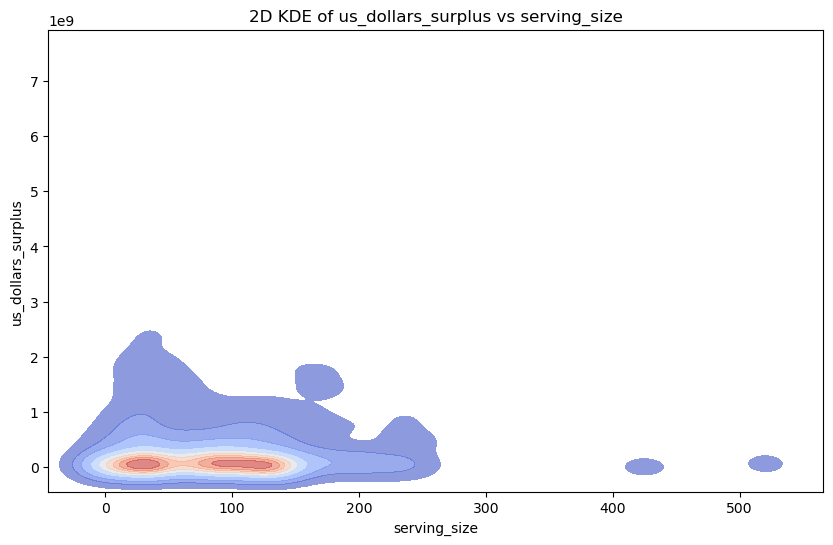

In [141]:
eda.plot_kde_2d(disposal_col='us_dollars_surplus', nutrient_col='serving_size')

The above Kernel Density Estimation (KDE) plot illustrates that foods with serving sizes between 40-60 grams and 150-200 grams are associated with surplus values in the range of 1-2.6 billion dollars. This suggests that both small and large serving sizes contribute significantly to food waste, with a considerable financial impact. The presence of these foods in the surplus category could indicate inefficiencies in portioning, consumption patterns, or supply chain management. Understanding the types of foods in these weight ranges can help target interventions aimed at reducing waste and mitigating associated economic losses.

## EDA Summary

1.	Correlation between Serving Size and Waste:

•	The plot of serving size against uneaten food shows a positive correlation, suggesting that larger serving sizes are associated with higher amounts of waste. The significant p-value confirms that this relationship is statistically robust. This implies that adjusting portion sizes could be an effective strategy to reduce food waste.

2.	Distribution of Calories:

•	The histogram reveals two distinct peaks in the distribution of calories, one in the 0-24 calorie range and another around 250 calories. The presence of outliers likely represents high-calorie meal-prep foods. This highlights the need for targeted interventions to reduce waste in high-calorie food items.
    
3.	Macronutrient Relationships:

•	The pair plot of macronutrients shows strong positive correlations between calories, fats, and carbs. Foods high in fats tend to also be high in carbs, while protein-rich foods generally have lower carb content. This insight can help guide interventions by identifying food categories that are resource-intensive and contribute to both environmental and economic waste.

4.	Food Disposal Methods:

•	The countplot of food waste disposal methods reveals that most food waste ends up in landfills, followed by composting, sewer waste, and animal feed recycling. This highlights the potential for nutrition-based interventions to reduce waste by shifting food from landfills to more sustainable disposal or repurposing methods.

5.	Correlations with Economic Surplus and Environmental Impact:

•	The correlation heatmap indicates that high protein and high fat foods are associated with higher environmental costs, in terms of water footprint, and contribute to significant economic losses when wasted. This suggests that reducing waste in these food categories could lead to both environmental and economic benefits.

•	Additionally, food waste that is recycled tends to overlap with food that could be donated, showing that improving donation systems could further reduce waste and benefit communities.

6.	Boxplot Insights on Waste by Caloric Value:

•	Boxplots show that higher-calorie foods are predominantly wasted in landfills or as animal feed, while lower-calorie foods are more likely to be composted or not harvested. This suggests that interventions targeting high-calorie foods could help mitigate their environmental and economic impacts.

7.	Water Footprint and Protein-Rich Foods:

•	The scatter plot with a trendline shows a positive correlation between protein-rich foods and their water footprint. This indicates that foods like meats, eggs, and dairy, which have high protein content, are resource-intensive to produce and contribute significantly to environmental degradation when wasted.

8.	Economic Surplus and Protein-Rich Foods:

•	The scatter plot of protein content versus US dollars surplus indicates that protein-rich foods also contribute significantly to economic loss when wasted. Reducing waste in these categories could alleviate substantial financial losses.

9.	Fiber Content and Recycling:

•	The scatter plot shows a weak positive correlation between fiber content and tons recycled, suggesting that fiber-rich foods, often organic, are more likely to be recycled. This may indicate that organic food waste has a higher chance of being repurposed or recycled.

10.	Food Rescue and Donation:

•	The hex bin plot suggests that foods with caloric values between 50-120 and 250-400 calories are most commonly donated. This points to specific food types that are frequently rescued and redistributed, possibly due to their suitability for donation and lower perishability.

11.	Caloric Value and Recycling:

•	The KDE plot indicates that foods with caloric values between 80-160 calories are most likely to be recycled, emphasizing that low-calorie foods are more easily repurposed when wasted. This suggests that low-calorie foods may have a higher chance of being repurposed through recycling or donation programs.

12.	Economic Surplus in Specific Serving Sizes:

•	The KDE of calories vs. tons donated shows that certain foods with serving sizes of 40-60 grams and 150-200 grams contribute to substantial economic surplus when wasted. This may point to specific types of foods that, despite their serving size, result in significant financial loss when wasted.

## Implications:

The findings highlight several key areas where interventions could reduce food waste:

•	Portion Control: Reducing portion sizes could lower the amount of food wasted, especially for larger servings.

•	Targeted Nutrition-Based Interventions: Focusing on high-calorie and protein-rich foods could reduce environmental and economic waste.

•	Recycling and Donation Programs: Encouraging the donation of low-calorie foods and improving recycling systems for fiber-rich foods could help repurpose waste.
	
•	Consumer and Organizational Action: Insights into food disposal methods and the impact of serving sizes can guide consumer behavior and organizational policies aimed at reducing food waste at all stages of the supply chain.